In [2]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
import scipy.io as sio
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
train_data = sio.loadmat('/content/drive/My Drive/Data/train_32x32.mat')
test_data = sio.loadmat('/content/drive/My Drive/Data/test_32x32.mat')
X_train, y_train = train_data['X'], train_data['y']
X_test, y_test = test_data['X'], test_data['y']
print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)
Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
y_train.shape,y_test.shape
num_images = X_train.shape[0] + X_test.shape[0]
print("Total Number of Images", num_images)


Total Number of Images 99289


In [0]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

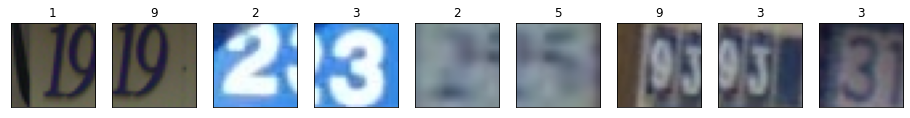

In [8]:


plot_images(X_train, y_train,1,9)


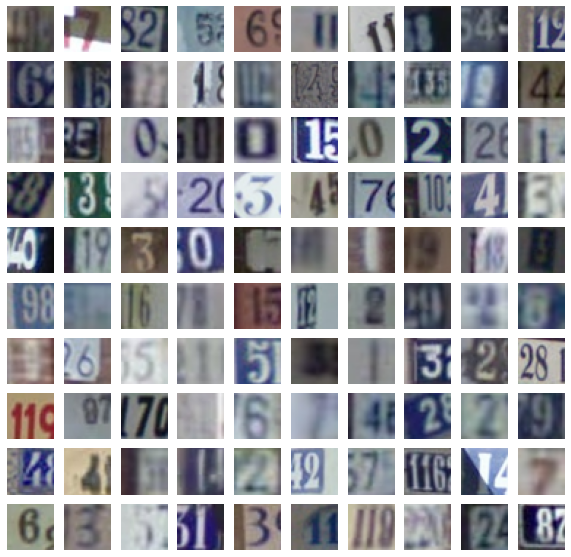

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

ROWS = 10

x = X_train.astype("uint8")

fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])

In [10]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [11]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

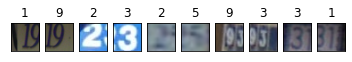

In [12]:
plot_images(X_train, y_train, 1, 10)

In [13]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200

NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = X_train.shape[3]

SUBTRACT_PIXEL_MEAN = True

DEPTH = COLORS * 9 + 2

In [0]:
def resnet_layer(inputs, num_filters=16,kernel_size=3,strides=1,activation='relu', batch_normalization=True, conv_first=True):
    
    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,num_filters=num_filters_in, conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,num_filters=num_filters_in,kernel_size=1, strides=strides, activation=activation,batch_normalization=batch_normalization,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_in,conv_first=False)
            y = resnet_layer(inputs=y, num_filters=num_filters_out,kernel_size=1, conv_first=False)
            if res_block == 0:
                
                x = resnet_layer(inputs=x,num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [0]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [0]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0


In [20]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [21]:
if SUBTRACT_PIXEL_MEAN:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', X_train.shape)

x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
y_train shape: (73257, 32, 32, 3)


In [22]:
from keras.utils import to_categorical

print(y_train[:100])


[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8 1 6 2 3 7 9 5
 3 2 2 2 6 2 2 5 1 5 4 7 8 9 6 0 1 2 4 5 6 5 2 1 3 2 1 4 6 3 8 4 3 1 4 4 2
 6 4 4 1 1 1 7 3 1 2 0 4 2 2 5 1 2 9 2 0 4 1 0 3 2 7]


In [23]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[:4]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
model = resnet_v2(input_shape=input_shape, depth=DEPTH)

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
t1 = datetime.now()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Data/weights.best.cnn1.hdf5", verbose=0, save_best_only=True) # save best model
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('/content/drive/My Drive/Data/weights.best.cnn1.hdf5') # load weights from best model

train_time = datetime.now() - t1

Epoch 1/1000
2290/2290 - 45s - loss: 1.2190 - accuracy: 0.7463 - val_loss: 0.8681 - val_accuracy: 0.8492
Epoch 2/1000
2290/2290 - 44s - loss: 0.6425 - accuracy: 0.9049 - val_loss: 0.6361 - val_accuracy: 0.8947
Epoch 3/1000
2290/2290 - 44s - loss: 0.5387 - accuracy: 0.9172 - val_loss: 0.5296 - val_accuracy: 0.9150
Epoch 4/1000
2290/2290 - 43s - loss: 0.4885 - accuracy: 0.9218 - val_loss: 0.4880 - val_accuracy: 0.9211
Epoch 5/1000
2290/2290 - 44s - loss: 0.4521 - accuracy: 0.9263 - val_loss: 0.4386 - val_accuracy: 0.9281
Epoch 6/1000
2290/2290 - 43s - loss: 0.4263 - accuracy: 0.9288 - val_loss: 0.4461 - val_accuracy: 0.9198
Epoch 7/1000
2290/2290 - 43s - loss: 0.4018 - accuracy: 0.9324 - val_loss: 0.4718 - val_accuracy: 0.9078
Epoch 8/1000
2290/2290 - 44s - loss: 0.3857 - accuracy: 0.9348 - val_loss: 0.4259 - val_accuracy: 0.9249
Epoch 9/1000
2290/2290 - 44s - loss: 0.3682 - accuracy: 0.9380 - val_loss: 0.3603 - val_accuracy: 0.9407
Epoch 10/1000
2290/2290 - 43s - loss: 0.3578 - accuracy

In [27]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

814/814 [==============================] - 5s 7ms/step - loss: 0.3603 - accuracy: 0.9407
Test loss: 0.36027991771698
Test accuracy: 0.9406883716583252


In [28]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred)
y_test = np.argmax(y_test, axis = 1)
print(y_test)

[5 2 1 ... 7 6 7]
[5 2 1 ... 7 6 7]


In [29]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.9406883835279656

In [30]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision-score: {}".format(score))

Precision-score: 0.9414093143397262


In [31]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall-score: {}".format(score))

Recall-score: 0.9406883835279656


In [32]:
score = metrics.f1_score(y_test,  y_pred, average= "weighted")
print("F1-score: {}".format(score))

F1-score: 0.940586078473413


In [0]:

classification = metrics.classification_report(y_test, y_pred)
from sklearn.metrics import confusion_matrix, classification_report

In [34]:

print(confusion_matrix)
print(classification)
print(accuracy)

<function confusion_matrix at 0x7fc3bd2411e0>
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1744
           1       0.94      0.96      0.95      5099
           2       0.97      0.96      0.96      4149
           3       0.95      0.91      0.93      2882
           4       0.92      0.98      0.95      2523
           5       0.98      0.89      0.93      2384
           6       0.91      0.93      0.92      1977
           7       0.93      0.95      0.94      2019
           8       0.95      0.90      0.92      1660
           9       0.91      0.92      0.92      1595

    accuracy                           0.94     26032
   macro avg       0.94      0.94      0.94     26032
weighted avg       0.94      0.94      0.94     26032

0.9406883835279656


In [0]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[1670   19   11    4    3    4    6    4    2   21]
 [  36 4908   23    8   72    4    6   34    5    3]
 [   4   29 3998   21   36    1    3   48    5    4]
 [   9   53   27 2614   32   17    7   12   35   76]
 [   5   31    6    3 2461    0    2    8    2    5]
 [   6   24   12   74   30 2118   84   14    8   14]
 [  37   27   12   12   16   11 1832   12   13    5]
 [   1   79    7    2    7    0    0 1922    0    1]
 [  25   21    8    8   17    1   73    3 1491   13]
 [  22   14   37    6    9    2    2   17   12 1474]]
Plotting confusion matrix


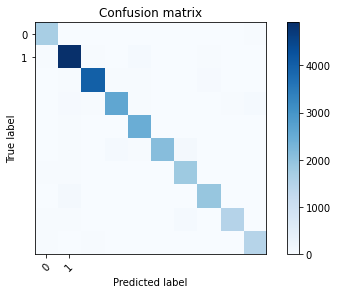

In [36]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

In [0]:
prediction_array = model.predict(X_test)
predicted_class = np.argmax(prediction_array, axis=1)

In [0]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[1670   19   11    4    3    4    6    4    2   21]
 [  36 4908   23    8   72    4    6   34    5    3]
 [   4   29 3998   21   36    1    3   48    5    4]
 [   9   53   27 2614   32   17    7   12   35   76]
 [   5   31    6    3 2461    0    2    8    2    5]
 [   6   24   12   74   30 2118   84   14    8   14]
 [  37   27   12   12   16   11 1832   12   13    5]
 [   1   79    7    2    7    0    0 1922    0    1]
 [  25   21    8    8   17    1   73    3 1491   13]
 [  22   14   37    6    9    2    2   17   12 1474]]
Plotting confusion matrix


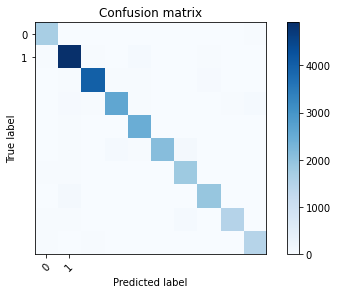

In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

In [0]:
prediction_array = model.predict(X_test)
predicted_class = np.argmax(prediction_array, axis=1)


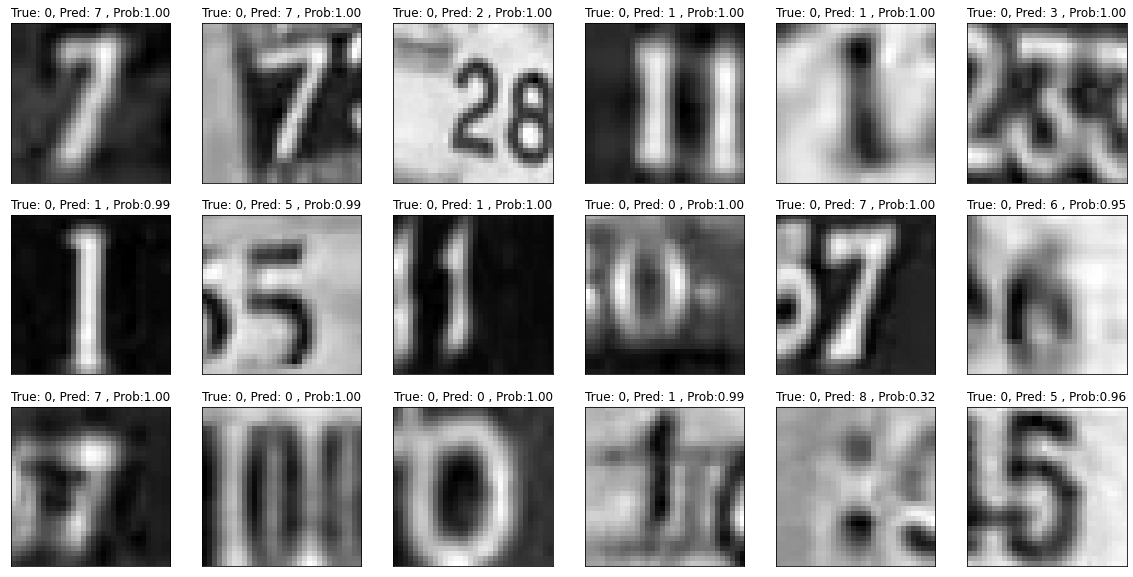

In [41]:
def plot_predicted_label(images, nrows, ncols, cls_true, cls_pred,prediction_array):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 10))
    
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        prob = round(prediction_array[i][cls_pred[i]],2)
        title = 'True: %s, Pred: %s , Prob:%0.2f' % (np.argmax(cls_true[i]),cls_pred[i],prob)
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])


# ploat image with predicted and actual value
num_rows = 3
num_cols = 6
plot_predicted_label(X_test,num_rows, num_cols, y_test,predicted_class,prediction_array);